In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

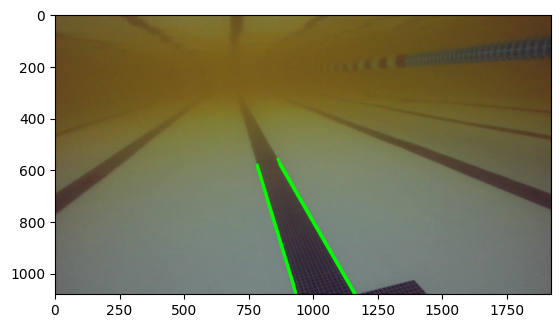

In [32]:
img = cv2.imread('rov_pool.jpg')
def normal_show(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, 40, 110, apertureSize=3) # detect edges


    slope_list=[]
    line_list=[]
    color_order=[(0,255,0),(0,0,255),(255,0,0),(100,100,100),(0,0,0),(150,30,90),(180,50,20)]
    color_order=[(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0)]
    i=0
    j=0

    lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                50,
                minLineLength=250,
                maxLineGap=150,
        ) # detect lines

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope=(y2-y1)/(x2-x1)
        slope_list.append(slope)
        line_list.append(([x1,y1,x2,y2]))
        i+=1
        i=i%6
        j+=1

        for k in range(len(slope_list)):
            if np.abs(slope)>.9:
                if round(slope,2) ==round(slope_list[k],2):
                    cv2.line(img,(x1,y1),(line_list[k][2],line_list[k][3]),color_order[i],10)
                else:
                    cv2.line(img, (x1, y1), (x2, y2), color_order[i], 2)
    plt.imshow(img)
normal_show(img)

In [33]:
cap = cv2.VideoCapture('AUV_Vid.mkv')
ret, frame = cap.read()

In [34]:
def Line_drawer(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, 50, 100) # detect edges using edge intensity of the gray version of the image.jpg,
    #  it detects the edges by establishing a color gradient along edges and using those gradients to define thin lines where edges should be,
    #  whether or not they are edges is then defined by whether the intensity of the shift in gradient is above or below certain thresholds
    #  that you define when calling Canny, so the second value you input is defined as the minimum threshold for gradient intensity,
    #  which if any edges have an intensity lower than that they are discarded, the second threshold is the maximum intensity, 
    #  which establishes that for any edges with a greater gradient intensity they are instantly accepted as edges, 
    #  and if some edges are in-between the thresholds, they are defined as edges or not based on whether they touch pixels that are a part of the edges.

    slope_list=[]
    line_list=[]

    color_order=[(0,255,0),(0,0,255),(255,0,0),(100,100,100),(0,0,0),(150,30,90),(180,50,20)] #Color cycle list
    color_order=[(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0)] # In case you want all green, yes this is a backwards solution
    i=0
    j=0

    lines = cv2.HoughLinesP(edges,1,np.pi/30,100,minLineLength=100,maxLineGap=10,) # detect lines
    # takes in edges, an array of lines mapped in cartesian space onto the image resolution
    # also takes in Rho which is distance resolution
    # then it takes in Theta which is angular pixel resolution
    # then it takes in a threshold for lines it will show, only lines that get more than the thresholds votes will be shown
    # then it takes in minLineLength which states the minimum length required in pixels for a line to be shown
    # then it takes in maxLineGap which states the maximum distance between two lines in points in a line for those points to be considered apart of a single line


    if lines is not None:
        for line in lines:
            if line is not None:
                x1, y1, x2, y2 = line[0]
                if (x2-x1)!=0:
                    pass
                elif (x2-x1)==0:
                    x2+=.1
                    
                slope=(y2-y1)/(x2-x1)
                slope_list.append(slope)
                line_list.append(([x1,y1,x2,y2]))
                i+=1
                i=i%6
                j+=1

                for k in range(len(slope_list)):
                    if np.abs(slope)>.9:
                        if round(slope,2) ==round(slope_list[k],2):
                            (cv2.line(img,(x1,y1),(line_list[k][2],line_list[k][3]),color_order[i],10))
                        else:
                            (cv2.line(img, (x1, y1), (x2, y2), color_order[i], 2))
                return(((cv2.line(img,(x1,y1),(line_list[k][2],line_list[k][3]),color_order[i],10))))
            else:
                pass
        else:
            pass
                
                

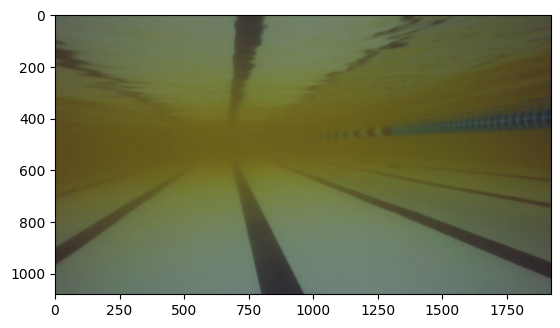

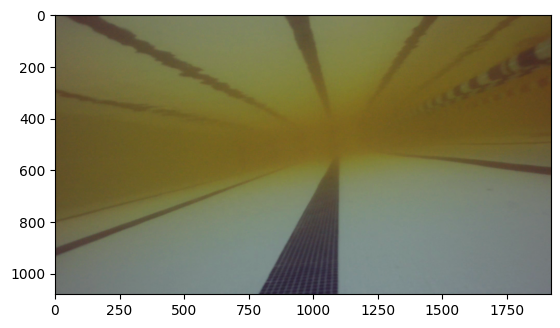

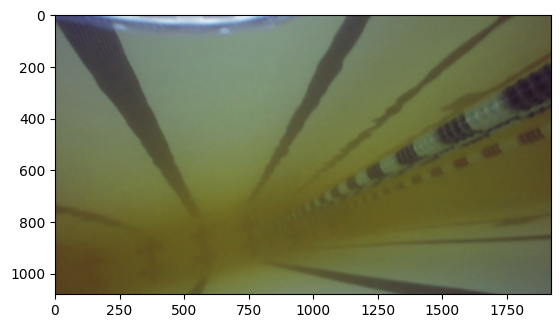

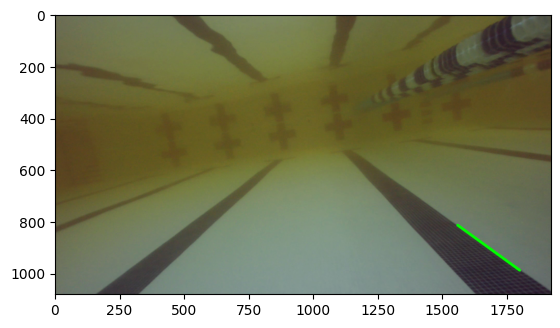

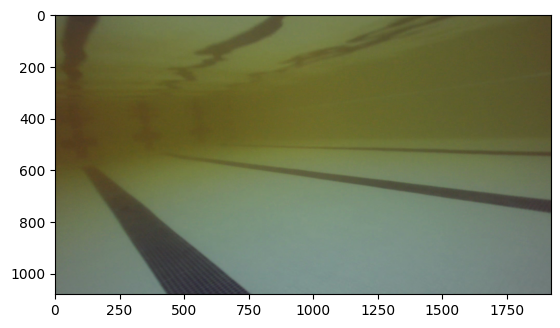

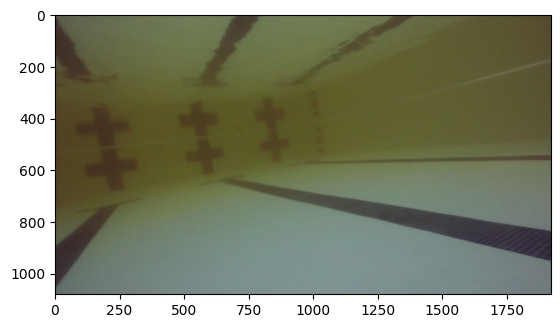

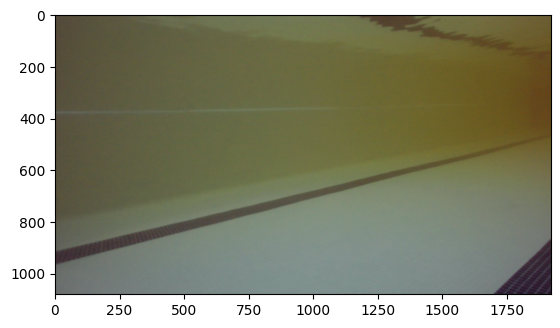

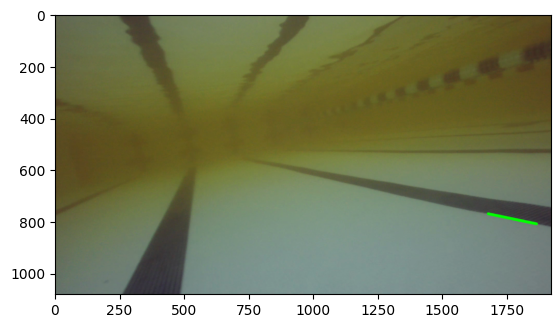

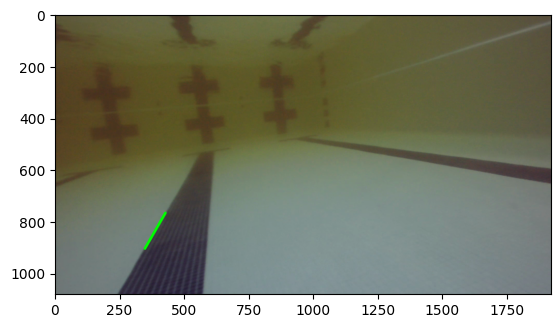

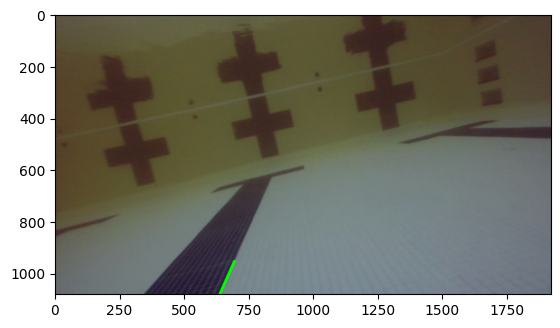

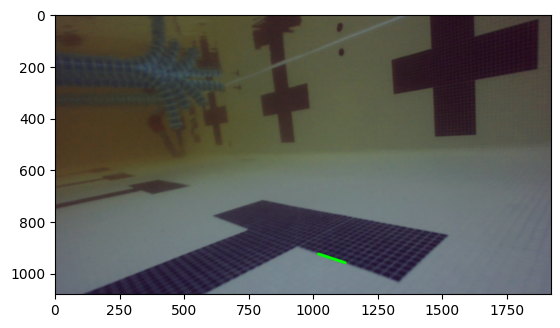

In [35]:
count=0
frequency=200
pic_list=[]
while ret:
    if count%frequency==0:
        pic_list.append((Line_drawer(frame)))
        plt.imshow(frame)
        plt.show()
        count+=1
    count+=1

    ret, frame = cap.read()
        

In [36]:
a=0
b=300

while ret:
    if a%b==0:
        plt.imshow(frame)
        plt.show()
        a+=1
    
    a+=1

    ret,frame = cap.read()

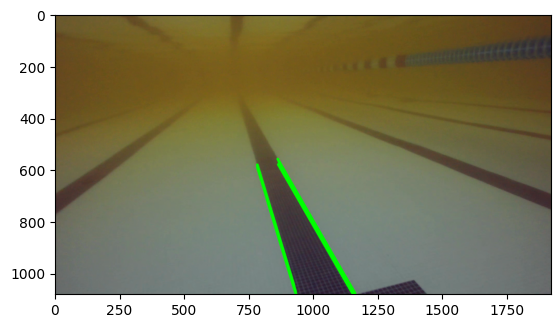

In [37]:
plt.imshow(Line_drawer(img))

In [ ]:
#!/usr/bin/env python
"""
BlueRov video capture class
"""

import cv2
import gi
import numpy as np

gi.require_version('Gst', '1.0')
from gi.repository import Gst


class Video():
    """BlueRov video capture class constructor

    Attributes:
        port (int): Video UDP port
        video_codec (string): Source h264 parser
        video_decode (string): Transform YUV (12bits) to BGR (24bits)
        video_pipe (object): GStreamer top-level pipeline
        video_sink (object): Gstreamer sink element
        video_sink_conf (string): Sink configuration
        video_source (string): Udp source ip and port
        latest_frame (np.ndarray): Latest retrieved video frame
    """

    def __init__(self, port=5600):
        """Summary

        Args:
            port (int, optional): UDP port
        """

        Gst.init(None)

        self.port = port
        self.latest_frame = self._new_frame = None

        # [Software component diagram](https://www.ardusub.com/software/components.html)
        # UDP video stream (:5600)
        self.video_source = 'udpsrc port={}'.format(self.port)
        # [Rasp raw image](http://picamera.readthedocs.io/en/release-0.7/recipes2.html#raw-image-capture-yuv-format)
        # Cam -> CSI-2 -> H264 Raw (YUV 4-4-4 (12bits) I420)
        self.video_codec = '! application/x-rtp, payload=96 ! rtph264depay ! h264parse ! avdec_h264'
        # Python don't have nibble, convert YUV nibbles (4-4-4) to OpenCV standard BGR bytes (8-8-8)
        self.video_decode = \
            '! decodebin ! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert'
        # Create a sink to get data
        self.video_sink_conf = \
            '! appsink emit-signals=true sync=false max-buffers=2 drop=true'

        self.video_pipe = None
        self.video_sink = None

        self.run()

    def start_gst(self, config=None):
        """ Start gstreamer pipeline and sink
        Pipeline description list e.g:
            [
                'videotestsrc ! decodebin', \
                '! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert',
                '! appsink'
            ]

        Args:
            config (list, optional): Gstreamer pileline description list
        """

        if not config:
            config = \
                [
                    'videotestsrc ! decodebin',
                    '! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert',
                    '! appsink'
                ]

        command = ' '.join(config)
        self.video_pipe = Gst.parse_launch(command)
        self.video_pipe.set_state(Gst.State.PLAYING)
        self.video_sink = self.video_pipe.get_by_name('appsink0')

    @staticmethod
    def gst_to_opencv(sample):
        """Transform byte array into np array

        Args:
            sample (TYPE): Description

        Returns:
            TYPE: Description
        """
        buf = sample.get_buffer()
        caps_structure = sample.get_caps().get_structure(0)
        array = np.ndarray(
            (
                caps_structure.get_value('height'),
                caps_structure.get_value('width'),
                3
            ),
            buffer=buf.extract_dup(0, buf.get_size()), dtype=np.uint8)
        return array

    def frame(self):
        """ Get Frame

        Returns:
            np.ndarray: latest retrieved image frame
        """
        if self.frame_available:
            self.latest_frame = self._new_frame
            # reset to indicate latest frame has been 'consumed'
            self._new_frame = None
        return self.latest_frame

    def frame_available(self):
        """Check if a new frame is available

        Returns:
            bool: true if a new frame is available
        """
        return self._new_frame is not None

    def run(self):
        """ Get frame to update _new_frame
        """

        self.start_gst(
            [
                self.video_source,
                self.video_codec,
                self.video_decode,
                self.video_sink_conf
            ])

        self.video_sink.connect('new-sample', self.callback)

    def callback(self, sink):
        sample = sink.emit('pull-sample')
        self._new_frame = self.gst_to_opencv(sample)

        return Gst.FlowReturn.OK


if __name__ == '__main__':
    # Create the video object
    # Add port= if is necessary to use a different one
    video = Video()

    print('Initialising stream...')
    waited = 0
    while not video.frame_available():
        waited += 1
        print('\r  Frame not available (x{})'.format(waited), end='')
        cv2.waitKey(30)
    print('\nSuccess!\nStarting streaming - press "q" to quit.')

    while True:
        # Wait for the next frame to become available
        if video.frame_available():
            # Only retrieve and display a frame if it's new
            frame = video.frame()
            cv2.imshow('frame', frame)
        # Allow frame to display, and check if user wants to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break